In [1]:
#import libraries
#!pip install plotly

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px

from scipy.stats import shapiro
from scipy.stats import kstest
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from plotly.subplots import make_subplots
from statsmodels.stats.power import TTestIndPower
from scipy import stats

from sklearn.cluster import KMeans


pd.options.mode.chained_assignment = None

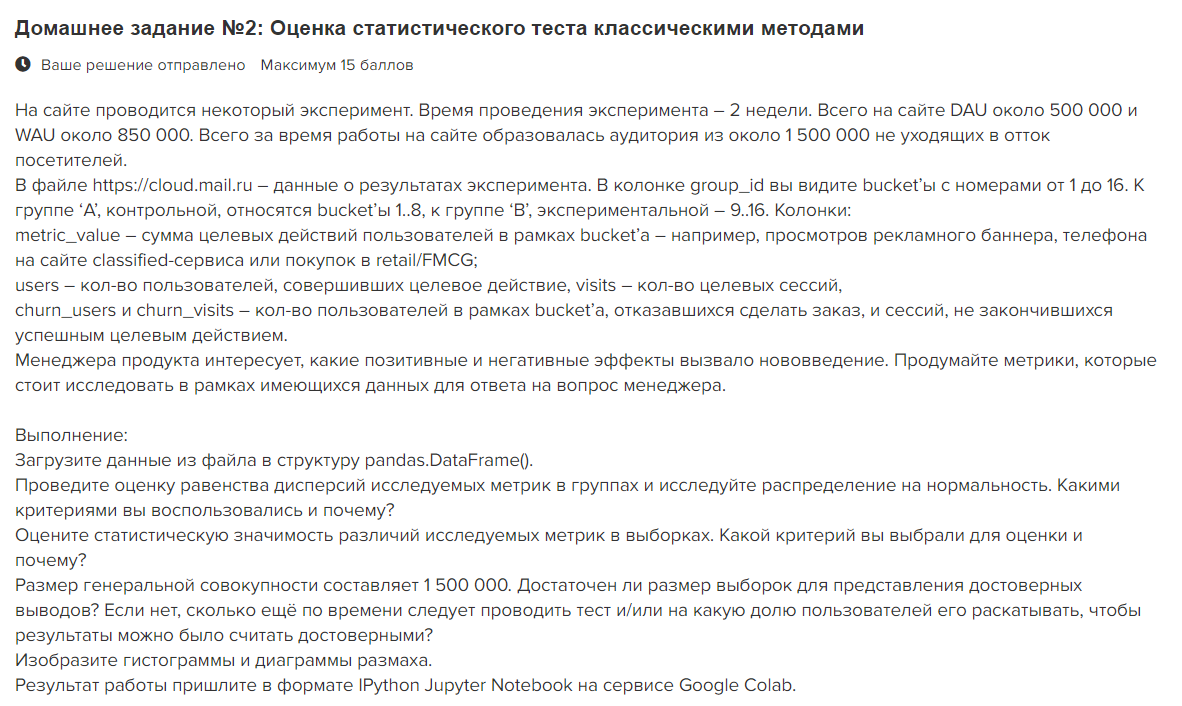

In [2]:
#import data
df_byuser = pd.read_csv("hw_abt_2_byuser.csv", delimiter = '\t' )
df2_bybucket = pd.read_csv("hw_abt_2_bybucket.csv", delimiter = '\t' )

In [3]:
#test and default group
test_byuser = df_byuser[df_byuser.group=='A']
default_byuser = df_byuser[df_byuser.group=='B']
default_bybucket = df2_bybucket[0:8]
test_bybucket = df2_bybucket[8:16]
print(test_byuser.shape, default_byuser.shape, test_bybucket.shape, default_bybucket.shape)

(2451, 8) (2549, 8) (8, 6) (8, 6)


In [4]:
df_byuser.head()

Unnamed: 0  group_id  metric_value  users  visits  churn_users  \
0           0         8      6630.000      0       0            0   
1           1        13      6933.976      0       0            1   
2           2        10      8261.976      1      10            1   
3           3         4      5522.000      1       9            1   
4           4        16      5075.976      1       6            0   

   churn_visits group  
0             8     A  
1             6     B  
2             8     B  
3             7     A  
4             8     B

In [5]:
df2_bybucket.head()

group_id  metric_value  users  visits  churn_users  churn_visits
0         1     1875345.0    155    1419          151          2207
1         2     1662237.0    138    1320          127          1853
2         3     1784372.0    128    1281          159          2032
3         4     1876826.0    163    1644          168          2172
4         5     1913180.0    156    1675          174          2273

Описание данных:

__metric_value__ - сумма целевых действий пользователей в рамках bucket’а <br>
__users__ - кол-во пользователей, которые совершили целевой визит <br>
__visits__ - кол-во целевых сессий <br>
__churn_users__ - кол-во пользователей в рамках bucket’а, отказавшихся сделать заказ <br>
__churn_visits__ - сессии, не закончившихеся успешным целевым действием <br>

# Первичный анализ пользователей. 

**users = 1  & churn_users = 1** : у пользователя был минимум 1 успешный заказ в рамках периода эксперимента, но так же были и визиты/заходы в приложение, при которых он заказ не сделал. 

**users = 0 (there's always visits = 0, but churn_visits > 0) & churn_users = 0** : пользователь ещё не совершил целелевого действия, но и не записан в charn_users, а ещё не имеет ни одного полезного vitits, но имеет не целевые посещения. Возможно, это новые пользователи, которые только недавно узнали о нашем сайте и за всё время не успели совершить целевой сессии, только изучают наш магазин.

**users = 1 & churn_users = 0** : пользователь совершил целевое действие, возможно не однократно, это активные пользователи.

рассмотрим отдельно **users = 1 & visits = 0 & churn_users = 0** : пользователь совершил целевое действие, и сделал это так быстро, что сессия не успела посчитаться за visits. Например,быстро зашел в наш интернет - магазин, сделал заказ и вышел.

**users = 0 & churn_users = 1** : пользоваетель не совершал за всё время целевое действие, он также давно не заходил на сайт (магазин), что попал в churn_users.

Хотелось бы отдельно рассмотреть кластер пользователей с **users = 0 & visits = 0 & metric_value > 0 (2541!!! из 5000)** : НЕ совершил целевое действие, НЕ имеет ни одного целевого сеанса, но имеет matric_value > 0. Как такое могло произойти ? Давайте попробуем разобраться. Для этого, полагаю, стоит понять возможные цели эксперимента.

  <img src="https://lh5.googleusercontent.com/-gghcW58gDzg/AAAAAAAAAAI/AAAAAAAAEA0/McGpTa3Wvog/photo.jpg?sz=328" alt="1"  width = 200>

# Предположим цели эксперимента на основе имеющихся данных

При проведении тестирования возможны различные виды выбора необходимых целей. Сами по себе цели также могут быть классфицированны по разному это всё зависит от конкретного случая и цели заказчика. В зависимости от необходимой задачи выстраивают маркетинговый план, делают бизнес-модель и выбирают нужную цель. <br>
Но сейчас, исходя из данных, проанализированных выше, я хочу остановится на типе целей, которые называются "составные цели". Составная цель сочетает в себе различные типы целей (Просмотры страниц с различными условиями и тд.). В ней можно задать несколько шагов последовательности, а в один шаг можно добавлять свои условия.

  <img src="https://osipenkov.ru/wp-content/uploads/2019/07/celi-yandex-metrika-24.jpg" alt="1"  width = 400>


Условия в шагах объединяются логическим оператором **ИЛИ**, то есть цель будет достигнута тогда, когда будет выполнено хотя бы одно из условий в шаге. <br>
Чтобы составная цель была достигнута, необходимо, чтобы было выполнен ряд требований: <br>
1) шаги должны быть выполнены в рамках одного визита посетителя; <br>
2) посетитель должен совершить шаги только в той последовательности, которая указана в настройках цели; 

При этом пользователь во время визита может посещать и другие страницы или совершать любые действия на сайте, которые не входят в составную цель. Это никак не повлияет на достижение цели. Самое главное – соблюдать последовательность!<br>
Рассмотрим пример:
  <img src="https://osipenkov.ru/wp-content/uploads/2019/07/celi-yandex-metrika-26.jpg" alt="1"  width = 900>


Есть составная цель из трех шагов:<br>
Шаг 1. Корзина <br>
Шаг 2. Доставка <br>
Шаг 3. Подтверждение заказа <br>
И было совершено 3 визита: <br>
1 визит с последовательностью Шаг 1 – Шаг 2 – Шаг 3 (цель достигнута); <br>
1 визит с последовательностью Шаг 1 – Промежуточные действия в виде просмотра других страниц сайта, совершения событий и т.д. – Шаг 2 – Шаг 3 (цель достигнута); <br>
1 визит с последовательностью Шаг 2 – Шаг 3 – Шаг 1 (цель не достигнута). <br>
В первом случае цель будет достигнута потому, что пользователь последовательно выполнил все шаги цели. Во втором случае цель также будет достигнута по причине того, что он последовательно выполнил все шаги цели, несмотря на посещение других страниц сайта и выполнениях иных действий. А вот третий визит не достиг цели, поскольку выполнил все шаги цели, но не по порядку.

Как это применимо к нашим данным ? Всё просто! (надеюсь, что я прав :)). Предположим, что на нашем сайте имеется составная цель из n шагов. Пользователю бедут присвоен users = 1 только в том случае, если он последовательно пройдет все n шагов за визит. В случае, если пользователь нарушит последовательность / совершит не все целевые действия в составной цели, то его визит будет = churn_visits и соотвественно users = 0. Осталось понять самое главное: почему metric_value > 0 ?? В процессе совершения основных действий, как я говорил выше, пользователь может совершать и промежуточные действия, которые также влияют на metric_value, но совершение промежуточных действий не влияет на значения visits и users, так как эти действия не являются основными.

Рассмотрим пример:

Имеется составная цель из n шагов, конечный результат которой - это покупка пользователем товара в интернет-магазине. Метрики users , visits будут засчитываться только за выполнении данной составной цели. <br>
Так же имеются и другие промежуточные цели: просмотр рекламного объявления, использование нового фильтра, кол-во кликов по обновленной кнопке и тд. <br>
Пользователь X, который зашел на сайт и начал искать товары с использованием нового фильтра, а после чего кликнул на обновленную кнопку, посмотрел товары, в итоге разочаровавшись в магазине- ушел. X совершил промежуточные действия, которые способствовали учелечению значения metric_value, однако так и не став целевым пользователем (user = 1) и не совершив целевого визита (visit >0 ). 

<img src="https://profiles.gfycat.com/ee8a4d42ce732582b763e18026fc1b15e6b8eaf44a3551dc34c62193b3cbb539.png" alt="1"  width = 200>

В заключении, выделим 4 группы пользователей исходя из имеющихся даннных. Эти группы пользователей мы будем использовать вдальнейшем.

**новые пользователи:** USERS = 0 & CHURN_USERS = 0<br>
**старые:** USERS = 1 & CHURN_USERS = 1<br>
**активные:** USERS = 1 & CHURN_USERS = 0<br>
**неактивные (бесполезные):** USERS = 0 & CHURN_USERS = 1<br>

In [6]:
#new
NEW_USERS = df_byuser.loc[(df_byuser['users']==0) & (df_byuser['churn_users']==0)]
#old
OLD_USERS = df_byuser.loc[(df_byuser['users']==1) & (df_byuser['churn_users']==1)]
#active
ACTIVE_USERS = df_byuser.loc[(df_byuser['users']==1) & (df_byuser['churn_users']==0)]
#unuseful
UNUSEFUL_USERS = df_byuser.loc[(df_byuser['users']==0) & (df_byuser['churn_users']==1)]

Посмотрим как распределены эти пользователи в тестовой и контрольной группе.

In [7]:
test_new = df_byuser.loc[(df_byuser['users']==0) & (df_byuser['churn_users']==0) & (df_byuser['group']=='A')]
default_new = df_byuser.loc[(df_byuser['users']==0) & (df_byuser['churn_users']==0) & (df_byuser['group']=='B')]

test_old = df_byuser.loc[(df_byuser['users']==1) & (df_byuser['churn_users']==1) & (df_byuser['group']=='A')]
default_old = df_byuser.loc[(df_byuser['users']==1) & (df_byuser['churn_users']==1) & (df_byuser['group']=='B')]

test_active = df_byuser.loc[(df_byuser['users']==1) & (df_byuser['churn_users']==0) & (df_byuser['group']=='A')]
default_active = df_byuser.loc[(df_byuser['users']==1) & (df_byuser['churn_users']==0) & (df_byuser['group']=='B')]

test_unuseful = df_byuser.loc[(df_byuser['users']==0) & (df_byuser['churn_users']==1) & (df_byuser['group']=='A')]
default_unuseful = df_byuser.loc[(df_byuser['users']==0) & (df_byuser['churn_users']==1) & (df_byuser['group']=='B')]


d = {'str':[1,2,3,4],'cls':['unusfl','old','new','active'],'test': [test_unuseful.metric_value.count()/len(test_byuser)*100, test_old.metric_value.count()/len(test_byuser)*100, test_new.metric_value.count()/len(test_byuser)*100,test_active.metric_value.count()/len(test_byuser)*100], 'default': [default_unuseful.metric_value.count()/len(default_byuser)*100,default_old.metric_value.count()/len(default_byuser)*100,default_new.metric_value.count()/len(default_byuser)*100,default_active.metric_value.count()/len(default_byuser)*100]}
df = pd.DataFrame(data=d)
df

str     cls       test    default
0    1  unusfl  25.336597  40.251079
1    2     old  25.010200  38.367987
2    3     new  25.826193  10.239310
3    4  active  23.827009  11.141624

In [8]:
import plotly.graph_objects as px

plot = px.Figure(data=[go.Bar(name = 'default,%',x = df['cls'],y = df['default']),
                       go.Bar(name = 'test,%',x = df['cls'],y = df['test'])])
plot.show()

## Выводы:

-на 15% уменьшилось кол-во "бесполезных" пользователей, т.е. пользовтелей, которые не взаимодействовали с нашим сайтом ни разу и уже давно не заходили на него

-на 13% уменьшилось кол-во активных пользователей, которые давно не заходили на сайт, т.е. пользователи стали больше взаимодействовать с сайтом и не уходить в отток

-на 15% увеличиось кол-во пользователей, которые еще никак не успели проявить себя, т.е. "новых пользователей"

-на 12% увеличилось кол-во активных пользователей, которые активно совершают целевые действия на сайте

# Определимся с метриками

Для расчета некоторых метрик и оценки рентабильности проекта нам понадобится учесть затраты, которые мы соврешили за данный период. Так как у нас нет информации о затратах, то зададим любое число.

In [9]:
COST = 110000;

Выберем метрики, которые будем изучать в дальнейшем. В этом пункте выполним только расчет метрик, а их анализ будем выполнять в последющем.<br>
Для начала рассмотрим метрики по бакетам. 

**Metrics:**<br>
**EG (Engagment Rate):** показатель вовлеченности. Формула: visits/(visits+churn_visits)x100<br>
**AOV (Average Order Value):** средний чек за 1 целевой визит. Формула: metric_value/ visits<br>
**CPA (Cost Per Action):** цена за 1 целевой визит. Формула: COST/visits <br>
**goals_per_session:** процент достижения цели за сессию. Формула: users/(visits+churn_visits)<br>

<img src="https://ie.wampi.ru/2021/12/06/Screenshot_13027ec0d41afc26c.jpg" alt="Screenshot 1" border="0">

In [10]:
df2_bybucket['EG'] = df2_bybucket['visits'] / (df2_bybucket['visits']+df2_bybucket['churn_visits'])*100 # это скорее eg - engagment_rate или CTR
df2_bybucket['AOV'] = df2_bybucket['metric_value'] / (df2_bybucket['visits']) # средний чек за 1 visit
df2_bybucket['CPA'] = COST / df2_bybucket['visits'] # cost per action
df2_bybucket['goals_per_session'] = df2_bybucket['users'] / (df2_bybucket['visits']+df2_bybucket['churn_visits'])*100 #

df2_bybucket

group_id  metric_value  users  visits  churn_users  churn_visits  \
0          1   1875345.000    155    1419          151          2207   
1          2   1662237.000    138    1320          127          1853   
2          3   1784372.000    128    1281          159          2032   
3          4   1876826.000    163    1644          168          2172   
4          5   1913180.000    156    1675          174          2273   
5          6   1733079.000    144    1509          141          2009   
6          7   1864555.000    151    1481          161          2139   
7          8   2029143.000    162    1533          153          2299   
8          9   2047289.536    143    1424          242          2191   
9         10   2228154.648    179    1803          265          2518   
10        11   1876015.920    150    1448          226          2062   
11        12   2102859.224    149    1339          261          2257   
12        13   2079287.344    155    1240          257          2248   
13        14   2127954.032    166    1397          256          2215   
14        15   1887384.920    161    1488          224          2015   
15        16   2082370.200    159    1469          273          2287   

           EG          AOV        CPA  goals_per_session  
0   39.134032  1321.596195  77.519380           4.274683  
1   41.601009  1259.270455  83.333333           4.349196  
2   38.665862  1392.952381  85.870414           3.863568  
3   43.081761  1141.621655  66.909976           4.271488  
4   42.426545  1142.197015  65.671642           3.951368  
5   42.893690  1148.495030  72.895958           4.093235  
6   40.911602  1258.983795  74.274139           4.171271  
7   40.005219  1323.641879  71.754729           4.227557  
8   39.391425  1437.703326  77.247191           3.955740  
9   41.726452  1235.804020  61.009429           4.142560  
10  41.253561  1295.591105  75.966851           4.273504  
11  37.235818  1570.469921  82.150859           4.143493  
12  35.550459  1676.844632  88.709677           4.443807  
13  38.676633  1523.231233  78.740157           4.595792  
14  42.477876  1268.403844  73.924731           4.596061  
15  39.110756  1417.542682  74.880871           4.233227

In [11]:
df2_bybucket.describe()

group_id  metric_value       users       visits  churn_users  \
count  16.000000  1.600000e+01   16.000000    16.000000    16.000000   
mean    8.500000  1.948128e+06  153.687500  1466.875000   202.375000   
std     4.760952  1.567561e+05   12.098037   147.824615    52.222441   
min     1.000000  1.662237e+06  128.000000  1240.000000   127.000000   
25%     4.750000  1.872648e+06  147.750000  1382.500000   157.500000   
50%     8.500000  1.900282e+06  155.000000  1458.500000   199.000000   
75%    12.250000  2.080058e+06  161.250000  1515.000000   256.250000   
max    16.000000  2.228155e+06  179.000000  1803.000000   273.000000   

       churn_visits         EG          AOV        CPA  goals_per_session  
count     16.000000  16.000000    16.000000  16.000000          16.000000  
mean    2173.562500  40.258919  1338.396823  75.678709           4.224159  
std      155.227991   2.154898   156.049627   7.350781           0.209319  
min     1853.000000  35.550459  1141.621655  61.009429           3.863568  
25%     2054.500000  39.002225  1253.188851  72.610651           4.130228  
50%     2199.000000  40.458411  1308.593650  75.423861           4.230392  
75%     2261.000000  41.901475  1422.582843  79.592833           4.293311  
max     2518.000000  43.081761  1676.844632  88.709677           4.596061

Теперь рассмотрим следующие поюзерные метрики.

**Metrics:**<br>
**churn_rate:** процент визитов, которые не закончились целевым действием. Формула: churn_visits/ (visits+churn_visits)x100<br>
**total_visits:** суммарное кол-во визитов пользователя. Формула: visits + churn_visits<br>
**diff_visits:** разница между целевыми визитами и churn_visits. Если >0, то целевых визитов больше, если < 0, то больше churn_visits. Формула: visits - churn_visits <br>

<img src="https://ie.wampi.ru/2021/12/06/Screenshot_2.jpg" alt="Screenshot 2" border="0">

In [12]:
df_byuser['churn_rate'] = df_byuser['churn_visits'] / (df_byuser['visits']+df_byuser['churn_visits'])*100 # процент churn session
df_byuser['total_visits'] = df_byuser['visits'] + df_byuser['churn_visits'] # все сессии
df_byuser['diff_visits'] = df_byuser['visits'] - df_byuser['churn_visits'] # >0 => полезных сессий больше , <0 => churn сессий больше
df_byuser

Unnamed: 0  group_id  metric_value  users  visits  churn_users  \
0              0         8      6630.000      0       0            0   
1              1        13      6933.976      0       0            1   
2              2        10      8261.976      1      10            1   
3              3         4      5522.000      1       9            1   
4              4        16      5075.976      1       6            0   
...          ...       ...           ...    ...     ...          ...   
4995        4995         6      3666.000      1       4            1   
4996        4996        12      6464.976      0       0            1   
4997        4997         1      4335.000      0       0            0   
4998        4998        13      6307.976      0       0            1   
4999        4999         2      5051.000      0       0            1   

      churn_visits group  churn_rate  total_visits  diff_visits  
0                8     A  100.000000             8           -8  
1                6     B  100.000000             6           -6  
2                8     B   44.444444            18            2  
3                7     A   43.750000            16            2  
4                8     B   57.142857            14           -2  
...            ...   ...         ...           ...          ...  
4995             5     A   55.555556             9           -1  
4996             8     B  100.000000             8           -8  
4997             8     A  100.000000             8           -8  
4998             8     B  100.000000             8           -8  
4999             8     A  100.000000             8           -8  

[5000 rows x 11 columns]

Следующим шагом будет рассмотрение агрегированных метрик. Эти метрики выражают показатель "здоровья" сайта, поэтому стоит обратить на них внимание. Рассчитаем их для тестовой и контрольной группы и создадим сводную таблицу.

**Metrics:**<br>
**ARPU (Average Revenue Per User):** средний доход от пользователей<br>
**Churn:** отток пользователей<br>
**LTV (Life Time Value):** <br>
**CAC (Customer Acquisition Cost):** стоимость привлечения клиента<br>
**CR (Conversion rate):** коэффициент конверсии. Соотношение посетителей сайта, достигших цели, к общей аудитории<br>
**AGR (Audience Growth Rate)** : показатель роста аудитории.<br>
**PF (Purchase Frequency)**: показатель частоты покупок<br>
**RPR (Repeat Purchase Rate)**: показатель повторных покупок<br>

<img src="https://ic.wampi.ru/2021/12/06/Screenshot_39cb1e9524832cf84.jpg" alt="Screenshot 3" border="0">

In [13]:
ARPU_default = sum(default_byuser['metric_value'])/len(default_byuser) # средний доход от пользователей
ARPU_test = sum(test_byuser['metric_value'])/len(test_byuser)
ARPU_default ,ARPU_test

(6446.181178501194, 6013.356589147287)

In [14]:
churn_default = sum(default_byuser['churn_users'][default_byuser['churn_users']==1])/len(default_byuser)*100 # отток пользователй в %
churn_test = sum(test_byuser['churn_users'][test_byuser['churn_users']==1])/len(test_byuser)*100
churn_default , churn_test

(78.61906630051, 50.3467972256222)

In [15]:
LTV_default = ARPU_default * 1 / churn_default # LTV
LTV_test = ARPU_test * 1 / churn_test
LTV_default , LTV_test

(81.99259393213346, 119.43871150729336)

In [16]:
#COST = 110000;
CAC_default = COST / sum(default_byuser['users'][default_byuser['users']==1])
CAC_test = COST / sum(test_byuser['users'][test_byuser['users']==1])
CAC_default , CAC_test

(87.16323296354992, 91.89640768588137)

In [17]:
CR_default = sum(default_byuser['users'][default_byuser['users']==1]) / len(default_byuser) *100
CR_test = sum(test_byuser['users'][test_byuser['users']==1]) / len(test_byuser) *100
CR_default , CR_test

(49.50961161239702, 48.837209302325576)

In [18]:
PF_default = sum(default_byuser['visits']) / len(default_byuser) 
PF_test = sum(test_byuser['visits']) / len(test_byuser) 
PF_default, PF_test

(4.553942722636328, 4.839657282741738)

In [19]:
RPR_default = sum(default_byuser['visits'][default_byuser['visits']>1]) / len(default_byuser) 
RPR_test = sum(test_byuser['visits'][test_byuser['visits']>1]) / len(test_byuser) 
RPR_default, RPR_test

(4.509611612397018, 4.798041615667075)

In [20]:
AGR_default = default_new.metric_value.count() / len(default_byuser) 
AGR_test = test_new.metric_value.count()/ len(default_byuser) 
AGR_default, AGR_test

(0.10239309533150255, 0.24833267948214988)

Анализ агрегированных метрик будет выполнен ниже.

# Оценка стат. значимости "бакетных метрик"

In [1]:
#test and default group
test_byuser = df_byuser[df_byuser.group=='A']
default_byuser = df_byuser[df_byuser.group=='B']
default_bybucket = df2_bybucket[0:8]
test_bybucket = df2_bybucket[8:16]
print(test_byuser.shape, default_byuser.shape, test_bybucket.shape, default_bybucket.shape)

NameError: name 'df_byuser' is not defined

In [22]:
default_bybucket.describe()

group_id  metric_value       users       visits  churn_users  \
count   8.00000  8.000000e+00    8.000000     8.000000       8.0000   
mean    4.50000  1.842342e+06  149.625000  1482.750000     154.2500   
std     2.44949  1.136543e+05   12.176529   140.119082      15.0119   
min     1.00000  1.662237e+06  128.000000  1281.000000     127.0000   
25%     2.75000  1.771549e+06  142.500000  1394.250000     148.5000   
50%     4.50000  1.869950e+06  153.000000  1495.000000     156.0000   
75%     6.25000  1.885914e+06  157.500000  1560.750000     162.7500   
max     8.00000  2.029143e+06  163.000000  1675.000000     174.0000   

       churn_visits         EG          AOV        CPA  goals_per_session  
count      8.000000   8.000000     8.000000   8.000000           8.000000  
mean    2123.000000  41.089965  1248.594800  74.778696           4.150296  
std      149.936177   1.697844    96.218491   7.186478           0.169525  
min     1853.000000  38.665862  1141.621655  65.671642           3.863568  
25%     2026.250000  39.787422  1146.920526  70.543541           4.057768  
50%     2155.500000  41.256305  1259.127125  73.585048           4.199414  
75%     2223.500000  42.543331  1322.107616  78.972868           4.272287  
max     2299.000000  43.081761  1392.952381  85.870414           4.349196

In [23]:
test_bybucket.describe()

group_id  metric_value       users       visits  churn_users  \
count   8.00000  8.000000e+00    8.000000     8.000000     8.000000   
mean   12.50000  2.053914e+06  157.750000  1451.000000   250.500000   
std     2.44949  1.189925e+05   11.297914   163.145859    18.023794   
min     9.00000  1.876016e+06  143.000000  1240.000000   224.000000   
25%    10.75000  2.007313e+06  149.750000  1382.500000   238.000000   
50%    12.50000  2.080829e+06  157.000000  1436.000000   256.500000   
75%    14.25000  2.109133e+06  162.250000  1473.750000   262.000000   
max    16.00000  2.228155e+06  179.000000  1803.000000   273.000000   

       churn_visits         EG          AOV        CPA  goals_per_session  
count       8.00000   8.000000     8.000000   8.000000           8.000000  
mean     2224.12500  39.427873  1428.198845  76.578721           4.298023  
std       152.67373   2.342917   156.495483   7.892411           0.229519  
min      2015.00000  35.550459  1235.804020  61.009429           3.955740  
25%      2158.75000  38.316429  1288.794290  74.641836           4.143259  
50%      2231.50000  39.251090  1427.623004  76.607021           4.253366  
75%      2264.50000  41.371784  1535.040905  79.592833           4.481803  
max      2518.00000  42.477876  1676.844632  88.709677           4.596061

Будем исследовать следующие метрики: users, visits, churn_users, churn_visits, EG, AOV, CPA, goals_per_session.

Как видно из анализа выше,практически во всех метриках прозошел рост, кроме: visits, EG.

Поэтому __выдвинем:<br> а) H<sub>0</sub>: M(X) = M(Y) при H<sub>1</sub>: M(X) > M(Y)__ для metric_value, users, churn_users и churn_visits,AOV, CPA, goals_per_session<br>__б) H<sub>0</sub>: M(X) = M(Y) при H<sub>1</sub>: M(X) < M(Y)__ для visits,EG<br>
где X - тестовая выборка, а Y - контрольная

и проверим наши гипотезы. Для начала сравним диспрсию двух выборок и проверим распределения на нормальность, чтобы определиться с выбором критерия.

Будем последовательно проверять <br>
а) имеют ли наши распределения нормальный вид<br>
б) равенство дисперсий в выборках<br>

## проверка на нормальность

__Гипотеза H<sub>0</sub>: X ~ N(μ,σ<sup>2</sup>) , Y ~ N(μ,σ<sup>2</sup>) при H<sub>1</sub>: X !~ N(μ,σ<sup>2</sup>) , Y !~ N(μ,σ<sup>2</sup>)__

Проверку этого условия будем производить Критерий Шапиро-Уилка. Почему именно этот критерий ? 

а) критерий используется при небольших выборках (n<50), в отличии от  критерия Колмогорова-Смирнова, который используют при больших выборках. Это важно, так как тесты нормальности чувствительны к размеру выборки.

б) он обладает более высокой мощностью по сравнению с критерием Колмогорова-Смирнова.

Поэтому в данном случае рационально использовать именно критерий Шапиро-Уилка.

Но перед тем как проводить тест, визуализируем наши данные, используя гистограммы, bar plot и q-q plot.

In [24]:
def create_hist(features, test_data, default_data):
    fig = make_subplots(rows=len(features), cols=2)
    for i in range(0,len(features)):
        fig.append_trace(go.Histogram(x=test_data[features[i]], nbinsx=5,name = '{}: test_group'.format(features[i]),marker_color='blue',opacity = 0.75), i+1, 1)
        fig.append_trace(go.Histogram(x=default_data[features[i]], nbinsx=5,name = '{}: default_group'.format(features[i]),marker_color='red',opacity = 0.75), i+1, 2)
    fig.show()

In [25]:
features = ['users', 'churn_users' , 'churn_visits','visits','EG','AOV', 'CPA', 'goals_per_session']
create_hist(features,test_bybucket,default_bybucket)

In [26]:
def create_box(features,data):
    plt.subplots_adjust(hspace =0.5,wspace = 0.3,top = 3,bottom = 0.5, right = 2)
    for i in range(0,len(features)):
        fig = plt.subplot(len(features),2,i+1)
        fig.boxplot(data[features[i]])
        fig.set_title('{}'.format(features[i]))

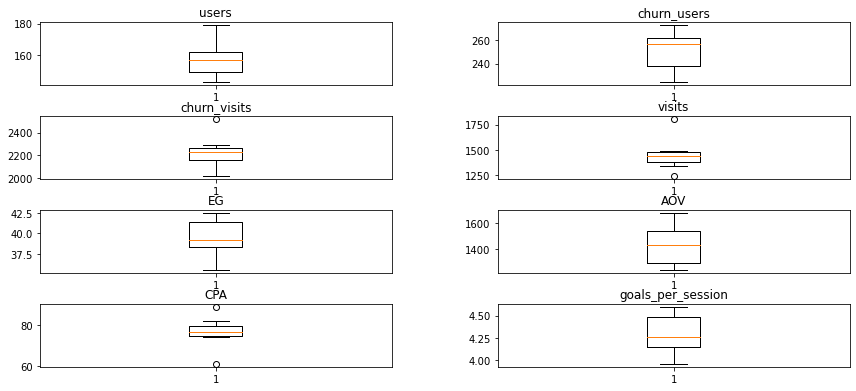

In [27]:
create_box(features,test_bybucket)

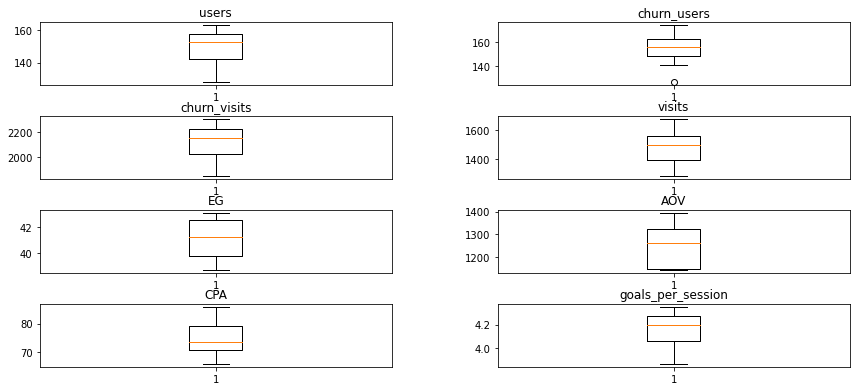

In [28]:
create_box(features,default_bybucket)

Видно, что данные имеют не нормальное распределение. Присутствует смещение среднего на box_plot'ах, имеются перекосы в квантилях. Также из анализа гистограмм понятно, что данные не имеют нормальное распределение. Однако, эти утверждения могут быть ошибочными в связи с тем, что выборки малого колличества (n=8), поэтому в дальнейшем проверим мои высказывания на стат. тестах. Но перед этим предлагаю построить qqplots.

(None, None)

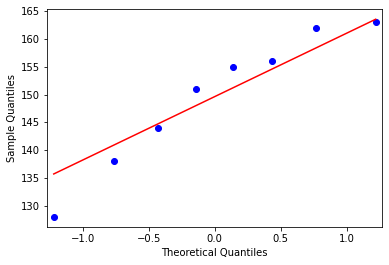

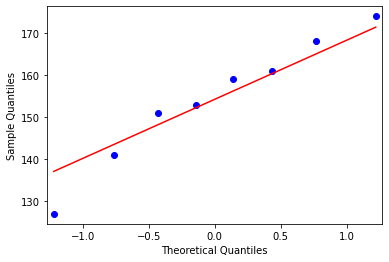

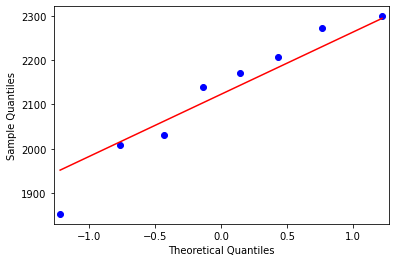

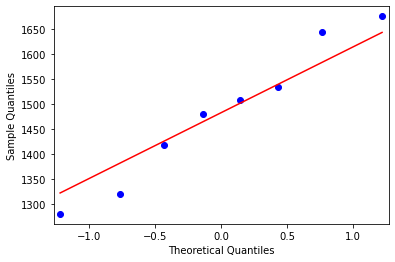

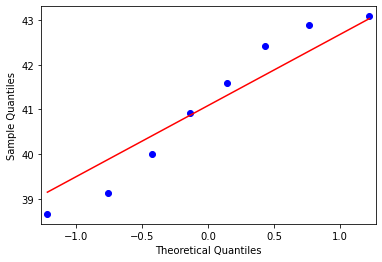

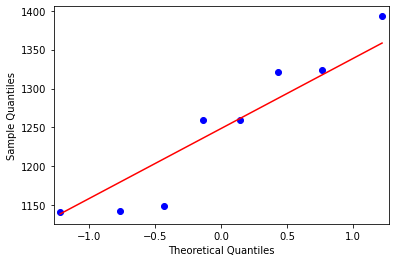

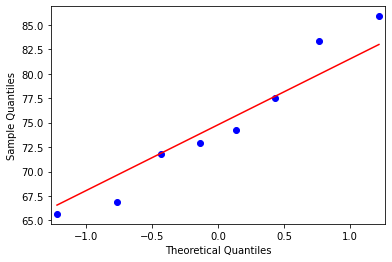

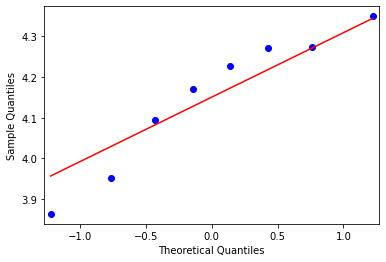

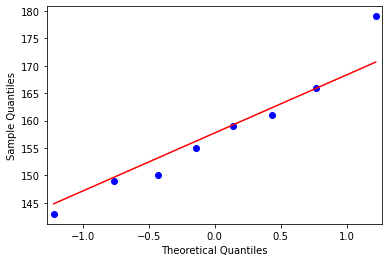

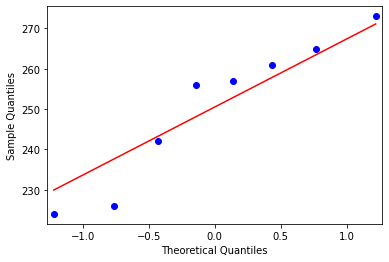

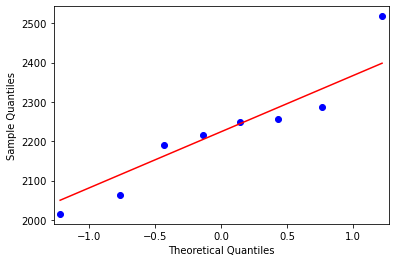

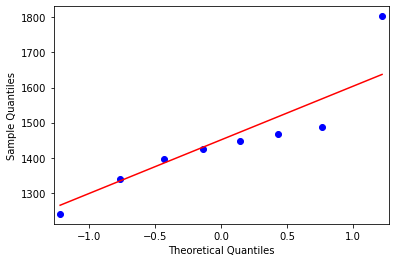

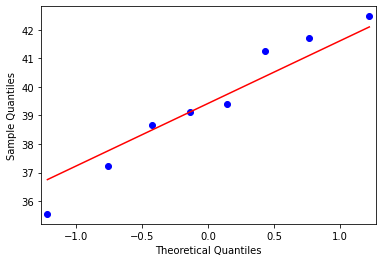

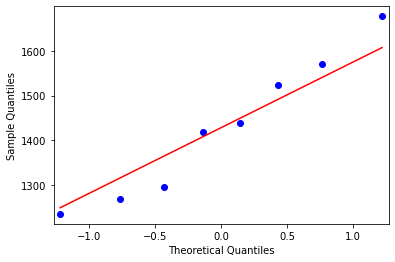

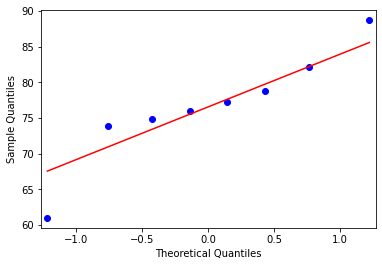

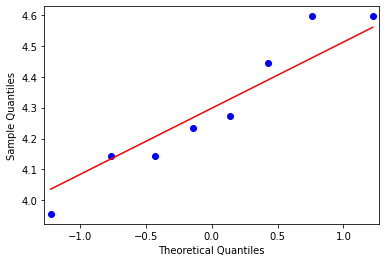

In [29]:
def create_qq(features,data):
    for i in range(0,len(features)):
        qqplot(data[features[i]], line='s')
create_qq(features,default_bybucket) , create_qq(features,test_bybucket)

Построив qq-plots мы ещё больше убедились в ненормальности данных :) Но, повторюсь, это так из-за малого объема выборки. А теперь давайте взглянем на результаты наших стат.тестов.

In [30]:
#test groups on normal distribution
alpha = 0.05

for i in range(len(features)):
    print("Testing: {}".format(features[i]))
    series_default = default_bybucket[features[i]] 
    st = shapiro(pd.Series(series_default))
    print(st)
    print('Distributions is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

    series_test = test_bybucket[features[i]] 
    st = shapiro(pd.Series(series_test))
    print(st)
    print('Distributions is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Testing: users
ShapiroResult(statistic=0.9316533207893372, pvalue=0.5312445759773254)
Distributions is normal

ShapiroResult(statistic=0.9615702629089355, pvalue=0.8249191641807556)
Distributions is normal

Testing: churn_users
ShapiroResult(statistic=0.967551052570343, pvalue=0.8781284093856812)
Distributions is normal

ShapiroResult(statistic=0.9051001071929932, pvalue=0.32084497809410095)
Distributions is normal

Testing: churn_visits
ShapiroResult(statistic=0.9461708664894104, pvalue=0.672615110874176)
Distributions is normal

ShapiroResult(statistic=0.9271014332771301, pvalue=0.490077406167984)
Distributions is normal

Testing: visits
ShapiroResult(statistic=0.9557231664657593, pvalue=0.7685189247131348)
Distributions is normal

ShapiroResult(statistic=0.8662515878677368, pvalue=0.13848599791526794)
Distributions is normal

Testing: EG
ShapiroResult(statistic=0.9265761375427246, pvalue=0.48545098304748535)
Distributions is normal

ShapiroResult(statistic=0.9617308378219604, pvalue

<img src="https://w7.pngwing.com/pngs/789/278/png-transparent-rage-comic-internet-meme-drawing-meme-white-face-monochrome.png" alt="1"  width = 200>

Хммм...странно получилось. Наш стат.тест Шапира Уилка показал, что все распределения нормальные. Но я бы не стал доверять его результатам, потому что выборки имеют малый размер. И полагаю, стоит отталкиваться от анализа гистограмм, boxplotов и qq-plotов. Таким образом, сделаем вывод, что данные в данном случае распределены **ненормально**.

## проверка равенства дисперсий в выборках

__Гипотеза H<sub>0</sub>: D(X)=D(Y) при H<sub>1</sub>: D(X) != D(Y)__

В этом пункте будем проверять равенство дисперсий. Выберем критерий из следующих трёх: F-критерий Фишера, критерий Бартлетта, критерий Левена.
F-критерий очень чувствителен к нормальности выборок, поэтому он может показывать неравенство дисперсий при малейшей их ненормальности, а как мы установили выше наши выборки в силу небольшого количества объема имеют ненормальное распределние. Соответственно, лучше проверить по тестам Левена и Бартлетта, так как они менее чувствительны к отклонению распределения от нормального. 

Проверку этого пункта будем вести критерием Барлетта,т.к. он имеет более высокую мощность по сравнению с критерием Левена. Однако после этого можно проверить результаты тестом Левена.

In [31]:
#check variance
alpha = 0.05 
for i in range(len(features)):
    print("Testing: {}\n".format(features[i]))
    series_default = default_bybucket[features[i]] 
    series_test = test_bybucket[features[i]] 
    st = bartlett(series_test, series_default)
    print(st)
    print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))
    st = levene(series_test, series_default)
    print(st)
    print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))
    print("Var of test selection:{} | Var of default selection:{}".format(series_test.var(), series_default.var()))

Testing: users

BartlettResult(statistic=0.0366101777787037, pvalue=0.8482608987310712)
Variances of distributions is equal

LeveneResult(statistic=0.05748282218870454, pvalue=0.8139943476156378)
Variances of distributions is equal

Var of test selection:127.64285714285714 | Var of default selection:148.26785714285714
Testing: churn_users

BartlettResult(statistic=0.21722871910329028, pvalue=0.6411596569307136)
Variances of distributions is equal

LeveneResult(statistic=0.16740478299379982, pvalue=0.6886192827142879)
Variances of distributions is equal

Var of test selection:324.85714285714283 | Var of default selection:225.35714285714286
Testing: churn_visits

BartlettResult(statistic=0.0021387186431563046, pvalue=0.9631139538294058)
Variances of distributions is equal

LeveneResult(statistic=0.05228493471937223, pvalue=0.822440295337027)
Variances of distributions is equal

Var of test selection:23309.26785714286 | Var of default selection:22480.85714285714
Testing: visits

BartlettR

Итак, оба тесты показали, что дисперсии двух выборок всех признаков равны, поэтому мы можем __принять нашу гипотезу о равенстве дисперсий__.

## проверка гипотез на стат.значимость

Теперь определимся с критерием для проверки стат. значимости <br>
Выбирать будем между T-критерием стьюдента и U-критерием Манна-Уитни.

__T-критерий стьюдента:__<br>
-требует выполнения определенных условий от наших выборок, а именно:<br>

а) данные в выборках должны быть распределены нормально<br>
б) дисперсии выборок должны быть равными<br>
в) выборки должны быть независимы

-используется для относительно больших выборок

__U-критерий Манна-Уитни:__<br>
-не требует выполнения вышеперечисленных условий<br>
-используется для небольших выборок, главное чтобы в каждой из выборок должно быть не менее 3 значений признака<br>

Наши выборки имеют малый объем (n=8), распределены не нормально и имеют равные дисперсии => лучше будет выбрать __критерий Манна-Уитни__ в силу небольшого объема выборок и отличия распределений от нормального вида.

Итак, проверим ранее выдвинутые гипотезы :

__а) H<sub>0</sub>: M(X) = M(Y) при H<sub>1</sub>: M(X) > M(Y)__ для metric_value, users, churn_users, churn_visits,AOV, CPA, goals_per_session<br>__б) H<sub>0</sub>: M(X) = M(Y) при H<sub>1</sub>: M(X) < M(Y)__ для visits,EG<br>
где X - тестовая выборка, а Y - контрольная

In [32]:
#tets on static significance

alpha = 0.05
for i in range(len(features)):
    print("Testing: {}\n".format(features[i]))
    series_default = default_bybucket[features[i]] 
    series_test = test_bybucket[features[i]] 
    st = mannwhitneyu(series_test, series_default)
    print('{}the H0: M(X)=M(Y) and {} the H1: M(X)>M(Y)\n'.format( {False:'Accept ',True:'Reject '}[st[1] < alpha],{False:'reject',True:'accept'}[st[1] < alpha])) 
    print(st,'\n')

Testing: users

Accept the H0: M(X)=M(Y) and reject the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=23.5, pvalue=0.2002337747859908) 

Testing: churn_users

Reject the H0: M(X)=M(Y) and accept the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=0.0, pvalue=0.00046955284955859495) 

Testing: churn_visits

Accept the H0: M(X)=M(Y) and reject the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=21.0, pvalue=0.13507426636425302) 

Testing: visits

Accept the H0: M(X)=M(Y) and reject the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=25.0, pvalue=0.24741826905654868) 

Testing: EG

Accept the H0: M(X)=M(Y) and reject the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=19.0, pvalue=0.09463148165751273) 

Testing: AOV

Reject the H0: M(X)=M(Y) and accept the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=11.0, pvalue=0.015662065438944998) 

Testing: CPA

Accept the H0: M(X)=M(Y) and reject the H1: M(X)>M(Y)

MannwhitneyuResult(statistic=25.0, pvalue=0.24741826905654868) 

Testing: goals_per_session

Accept the 

In [33]:
abs(default_bybucket['churn_users'].mean()-test_bybucket['churn_users'].mean()) , abs(default_bybucket['AOV'].mean()-test_bybucket['AOV'].mean())

(96.25, 179.6040450061455)

## Выводы:
Проанализируем результаты тестов.

Из тестов выше видно, что стат. значимы различия оказались только в 2-ух метриках. Это **churn_users** и **AOV**. В остальных метриках различия не стат.значимы и их различие может быть связано с многими факторами.

__churn_users__: кол-во пользователей, отказавшихся сделать заказ увеличилось в среднем на ~96 пользователей => __Это негативная сторона нововведения__.  <br>
__AOV__: средний чек за 1 целевой визит увеличился в среднем на ~180 y.e. => __Это положительная сторона нововведения__.  <br>

# Оценка стат. значимости поюзерных метрик

In [34]:
test_byuser.describe()

Unnamed: 0     group_id  metric_value        users       visits  \
count  2451.000000  2451.000000   2451.000000  2451.000000  2451.000000   
mean   2513.987760     4.552836   6013.356589     0.488372     4.839657   
std    1442.223383     2.304557   1706.147953     0.499967     8.789929   
min       0.000000     1.000000   1343.000000     0.000000     0.000000   
25%    1260.500000     3.000000   4744.000000     0.000000     0.000000   
50%    2513.000000     5.000000   6035.000000     0.000000     0.000000   
75%    3754.500000     7.000000   7303.500000     1.000000     6.000000   
max    4999.000000     8.000000  10862.000000     1.000000    66.000000   

       churn_users  churn_visits   churn_rate  total_visits  diff_visits  
count  2451.000000   2451.000000  2450.000000   2451.000000  2451.000000  
mean      0.503468      6.929417    77.066485     11.769074    -2.089759  
std       0.500090      1.944200    29.668663      8.980416     9.024281  
min       0.000000      0.000000     0.000000      0.000000    -9.000000  
25%       0.000000      6.000000    50.000000      7.000000    -8.000000  
50%       1.000000      7.000000   100.000000      9.000000    -5.000000  
75%       1.000000      9.000000   100.000000     13.000000     0.000000  
max       1.000000      9.000000   100.000000     73.000000    59.000000

In [35]:
default_byuser.describe()

Unnamed: 0     group_id  metric_value        users       visits  \
count  2549.000000  2549.000000   2549.000000  2549.000000  2549.000000   
mean   2485.569243    12.488035   6446.181179     0.495096     4.553943   
std    1444.911607     2.291621   1715.107559     0.500074     8.147190   
min       1.000000     9.000000   1616.976000     0.000000     0.000000   
25%    1242.000000    10.000000   5167.976000     0.000000     0.000000   
50%    2486.000000    12.000000   6454.976000     0.000000     0.000000   
75%    3743.000000    14.000000   7765.976000     1.000000     6.000000   
max    4998.000000    16.000000  10784.976000     1.000000    70.000000   

       churn_users  churn_visits   churn_rate  total_visits  diff_visits  
count  2549.000000   2549.000000  2547.000000   2549.000000  2549.000000  
mean      0.786191      6.980384    77.598103     11.534327    -2.426442  
std       0.410074      1.930404    28.767429      8.390589     8.354899  
min       0.000000      0.000000     0.000000      0.000000    -9.000000  
25%       1.000000      6.000000    52.941176      7.000000    -8.000000  
50%       1.000000      7.000000   100.000000      9.000000    -5.000000  
75%       1.000000      9.000000   100.000000     14.000000    -1.000000  
max       1.000000      9.000000   100.000000     79.000000    63.000000

Из анализа видно, что среднее всех метрик по юзерам особо не изменилось. Поэтому в данном случае интереснее будет сделать кластеризацию пользователей на 3 группы: лояльные клиенты (высокий показатель metric_value) , нейтральные (средний показатель metric_value) , критики (низкий показатель metric_value). После чего расчитать **Net Promouter Score** для тестовой и контрольной группы и сравнить результаты. 

**Net Promouter Score** = SUM(лояльные)% - SUM(критики)%

In [36]:
data = np.array(df_byuser["metric_value"]).reshape(-1, 1)
n_clusters = 3
kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
kmeans_clusters.fit(data)
df_byuser["user_cls"] = kmeans_clusters.labels_+1
df_byuser.head()

Unnamed: 0  group_id  metric_value  users  visits  churn_users  \
0           0         8      6630.000      0       0            0   
1           1        13      6933.976      0       0            1   
2           2        10      8261.976      1      10            1   
3           3         4      5522.000      1       9            1   
4           4        16      5075.976      1       6            0   

   churn_visits group  churn_rate  total_visits  diff_visits  user_cls  
0             8     A  100.000000             8           -8         3  
1             6     B  100.000000             6           -6         3  
2             8     B   44.444444            18            2         2  
3             7     A   43.750000            16            2         3  
4             8     B   57.142857            14           -2         1

In [37]:
test_byuser = df_byuser[df_byuser.group=='A']
default_byuser = df_byuser[df_byuser.group=='B']
test_byuser.head()

Unnamed: 0  group_id  metric_value  users  visits  churn_users  \
0           0         8        6630.0      0       0            0   
3           3         4        5522.0      1       9            1   
5           5         2        8539.0      0       0            0   
6           6         8        5714.0      0       0            0   
7           7         3        7330.0      0       0            0   

   churn_visits group  churn_rate  total_visits  diff_visits  user_cls  
0             8     A      100.00             8           -8         3  
3             7     A       43.75            16            2         3  
5             8     A      100.00             8           -8         2  
6             7     A      100.00             7           -7         3  
7             6     A      100.00             6           -6         2

In [38]:
loyals_default = default_byuser[default_byuser["user_cls"]==3]
neutrals_default = default_byuser[default_byuser["user_cls"]==2]
critics_default = default_byuser[default_byuser["user_cls"]==1]

loyals_test = test_byuser[test_byuser["user_cls"]==3]
neutrals_test = test_byuser[test_byuser["user_cls"]==2]
critics_test = test_byuser[test_byuser["user_cls"]==1]


d = {'str':[1,2,3],'cls':['loyals','neutrals','critics'],'test': [loyals_test.metric_value.count()/len(test_byuser)*100, neutrals_test.metric_value.count()/len(test_byuser)*100, critics_test.metric_value.count()/len(test_byuser)*100], 'default': [loyals_default.metric_value.count()/len(default_byuser)*100,neutrals_default.metric_value.count()/len(default_byuser)*100,critics_default.metric_value.count()/len(default_byuser)*100]}
df = pd.DataFrame(data=d)
df

str       cls       test    default
0    1    loyals  41.942064  39.348764
1    2  neutrals  27.131783  36.327972
2    3   critics  30.926153  24.323264

In [39]:
plot = px.Figure(data=[go.Bar(name = 'default,%',x = df['cls'],y = df['default']),
                       go.Bar(name = 'test,%',x = df['cls'],y = df['test'])])
plot.show()

In [40]:
NPS_test = len(test_byuser[test_byuser['user_cls']==3])/len(test_byuser)*100-len(test_byuser[test_byuser['user_cls']==1])/len(test_byuser)*100
NPS_default = len(default_byuser[default_byuser['user_cls']==3])/len(default_byuser)*100-len(default_byuser[default_byuser['user_cls']==1])/len(default_byuser)*100
NPS_test , NPS_default

(11.015911872705022, 15.025500196155352)

## Выводы:
Итак, видно, что показатель NPS, отвечающий за удовлетровенность потребителя товаром снизился на ~4%. Это связано с тем, что увеличилась доля критиков на сайте => **Это негативная сторона нововведения** <br>
Стоит отметить, что увелечение группы "критиков" произошло в основном из-за уменьшения группы "нейтральных" пользователей.

# Анализ агрегированных метрик

Давайте сначала создадим сводную таблицу из имеющихся метрик и посмотрим какие метрики у нас есть.

In [41]:
dict = {'data':["test", "default"],
        'ARPU': [ARPU_test, ARPU_default],
        'Churn':[churn_test, churn_default],
         'LTV': [LTV_test,LTV_default],
           'CAC': [CAC_test,CAC_default],
            'CR': [CR_test,CR_default],
           'AGR': [AGR_test,AGR_default],
           'PF':[PF_test, PF_default],
           'RPR': [RPR_test, RPR_default]}

In [42]:
df = pd.DataFrame(dict)
df

data         ARPU      Churn         LTV        CAC         CR  \
0     test  6013.356589  50.346797  119.438712  91.896408  48.837209   
1  default  6446.181179  78.619066   81.992594  87.163233  49.509612   

        AGR        PF       RPR  
0  0.248333  4.839657  4.798042  
1  0.102393  4.553943  4.509612

Хорошо, таблица создана...теперь хотелось бы оценить показатель здоровья нашего сайта, а дальше посмотреть на остальные метрики и сделать выводы по ним. Давайте приступим. Как будем оценивать показатель здоровья сайта ? <br>
По следующему несложному неравенству:<img src="https://ie.wampi.ru/2021/12/06/Screenshot_40b7b2d19dc2c3af9.jpg" alt="Screenshot 4" border="0">

т.е. если LVT > CAC - это хорошо, наш сайт приносит прибль, он рентабелен. Иначе - надо работать над улучшением проекта :( <br>
Посмотрим на данные показатели отдельно для тестовой, отдельно для контрольной группы.

Учтем, что ранее мы брали затраты для расчета метрик в 110.000 у.е., тогда для данного значения cost получим следующие результаты: <br>

Для тестовой группы : **LVT = 119 , а CAC = 92** <br>
Для контрольной группы: **LTV = 82, а CAC = 87** <br>
Видим, что в случае контрольной группы наш сайт терпит убытки, а в случае тестовой - всё хорошо, наш сайт "здоров".

Также заметим значительный прирост по LTV на 37% и снижение CAC на 5% между контрольной и тестовой группой. Это не может не радовать :)

Проанализируем остальные метрики:

- **ARPU снизился на 433 у.е.**, т.е. в среднем в тестовой выборке пользователи стали тратить меньше, чем тратили до этого в контрольной :(
- в тестовой выборке **уменьшился показатель оттока клиентов на 28%**, пользователи стали более заинтересованы нашим сайтом :)
- конверсия практически не увеличилась, т.е. доля пользователей, совершивших заказ осталась почти такой же :/
- заметен **прирост новой аудитории на 14%** в тестовой выборке :)
- показатель частоты покупкок остался практически неизменным
- аналогичное утверждение можно привести о частоте повторных покупок

# Посчитаем размер выборки и дадим заключение о достоверности результатах

При расчете выборки будем использовать TTestIndPower. 

Зададим мощность критерия: power = 0.8

Зададим уровень значимости: alpha = 0.05

Рассчитаем MDE, основывыясь на имеющихся данных. <br>Расчёт будем вести по целевой метрике (metric_value) и оценим уровень её прироста в тестовой группе.<br> Формула для вычисления: *MDE=(mean(test)-mean(default)/(mean(test)*100*

In [43]:
effect = abs(test_byuser['metric_value'].mean()-default_byuser['metric_value'].mean()) / test_byuser['metric_value'].mean()
effect
print('Размер эффекта составил {} %'.format(effect*100))

Размер эффекта составил 7.197720323704981 %


In [44]:
effect = 0.072
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size for each group: {} with mde: {} %'.format(round(result,3),round(effect*100),3))
print('Sample Size as test group: {}'.format(len(test_byuser)))
print('Sample Size as default group: {}'.format(len(default_byuser)))

Sample Size for each group: 3029.07 with mde: 7 %
Sample Size as test group: 2451
Sample Size as default group: 2549


Видим, что нам не хватает для предоставления достоверных выводов набрать ~500 пользователей в каждую из групп. т.е. общее колличество пользователей, которых ещё необходимо набрать для теста ~1000.

Учитывая текущую динамику: 5000 пользователей за 14 дней, то для набора 1000 пользователей потребуется **~ ещё 3 дня.** Таким образом необходимо подождать ещё немного времени и уже после набора необходимого колличества пользователей говорить о стат.значимых различиях.

# Выводы

<img src="https://avatars.mds.yandex.net/get-zen_doc/53963/pub_5bb5f238849b0200ad26e0fe_5bb62385374f9d00abf46ff1/scale_1200" alt="1"  width = 400>

А теперь предлагаю поговорить о самом интересном и подвести итог всему тому, что мы разобрали выше. Сделаем выводы о проделанной работе, покажем как нововведения повлияли на работу сайта, посмотрим какие метрики увеличились, какие просели, какие остались без изменений.

**Позитивные моментs нововведения :)**

- **на 15% уменьшилось кол-во "бесполезных"** пользователей, т.е. пользовтелей, которые не взаимодействовали с нашим сайтом ни разу и уже давно не заходили на него

- **на 13% уменьшилось** кол-во активных пользователей, **которые давно не заходили на сайт**, т.е. пользователи стали больше взаимодействовать с сайтом и не уходить в отток

- **на 15% увеличиось** кол-во пользователей, которые еще никак не успели проявить себя, т.е. **"новых пользователей"**

- **на 12% увеличилось кол-во активных** пользователей, которые активно совершают целевые действия на сайте

- **средний чек за 1 целевой визит** (AOV) **увеличился в среднем на ~180 y.e.**, причем это увелечение стат.значимо

- значительный **прирост по LTV на 37%** в тестовой группе

- **снижение CAC на 5%** между контрольной и тестовой группой

- в тестовой выборке **уменьшился показатель оттока клиентов (churn) на 28%**, пользователи стали более заинтересованы нашим сайтом

- есть **прирост новой аудитории на 14%** в тестовой выборке по стравнению с контрольной

**Негативные моментs нововведения :(**

- кол-во пользователей, **отказавшихся сделать заказ (churn_users) увеличилось в среднем на ~96 пользователей**, причем это увелечение стат. значимо

- показатель **NPS**, отвечающий за удовлетровенность потребителя товаром, **снизился на ~4%.** Это связано с тем, что увеличилась доля критиков на сайте. Увелечение группы "критиков" произошло в основном из-за уменьшения группы "нейтральных" пользователей.

- **средний чек на одного пользователя (ARPU) снизился на 433 у.е.**, т.е. в среднем в тестовой выборке пользователи стали тратить меньше, чем тратили до этого в контрольной. Хотя, как я показал выше, за каждый визит пользователи стали тратить больше у.е.

**Метрики, которые не изменились в результате теста :\**

- оказались не стат. значимы изменения следующих метрик: users, churn_visits, CPA, goals_per_session, visits и EG.

- так же незначительные изменения были получены в: конверсии заказов, показателе частоты покупок и частоте повторной покупки клиентом.


**Общий вывод:**

В общем и целом, считаю, что на сайте произошло больше положительных изменений, чем негативных (хотя и негативные тоже довольно существенные. Взять тот же ARPU, который уменьшился на 433 у.е.), поэтому стоит раскатывать новведения на всех пользователей. Но для начала нужно всё таки дождаться пока наберётся выборка, которая предоставляет возможность делать вывводы о достоверности результатов. После посмотреть на метрики ещё раз и принимать решение.

Так же, может быть стоит протестировать другие варианты нововведений, которые нивилируют негативные изменения, но сохраняют полученный профит или даже улучшая его.

<img src="http://risovach.ru/upload/2013/03/mem/kosmos-ohuenno_14308608_orig_.jpeg" alt="1"  width = 600>

На этом всё. Спасибо :)